In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import h5py
pie = np.pi

2022-05-27 16:37:55.160014: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-27 16:37:55.160037: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
hbar_box = 6.582
c_box = 2.99
pc_box = 3.0857
h = 0.7
alpha = 0.175
hbar_by_m_val = (hbar_box*h*c_box*c_box/(alpha*pc_box))*0.001
H0_val = 100.0
da_val = 0.00001
a0_val = 1.0
ai_val = 0.0078125
a_print = (int)((a0_val-ai_val)/(10.0*da_val))
print(a_print,hbar_by_m_val)
hbar_by_m_val*pie*128

9921 0.07627927303367146


30.673715684320292

In [3]:

def pcube(p):
    pivot = np.floor(p/dx).astype(int)
    a001 = np.array([0,0,1])
    a010 = np.array([0,1,0])
    a100 = np.array([1,0,0])
    
    a011 = np.array([0,1,1])
    a110 = np.array([1,1,0])
    a101 = np.array([1,0,1])
    
    a111 = np.array([1,1,1])
    
    p001 = pivot+a001
    p010 = pivot+a010
    p100 = pivot+a100
    p011 = pivot+a011
    p110 = pivot+a110
    p101 = pivot+a101
    
    p111 = pivot+a111
    
    part_cube =np.stack([pivot,p100,p010,p001,p110,p011,p101,p111],axis=0)

    return part_cube


def pic_dc_construct(p,v,n,dx):
    p_cube_ind = pcube(p)
    p_cube = p_cube_ind*dx
    d = np.prod((1.0-np.absolute(p-p_cube)/dx),axis=2)
    
    n_part = np.max(p_cube.shape)
    print(n_part)
    
    dc=np.zeros((n,n,n))
    vel=np.zeros((n,n,n,3))
    
    for i in range(n_part):
        for j in range(8):
            m = (128+(p_cube_ind[j,i,0]))%128
            n = (128+(p_cube_ind[j,i,1]))%128
            k = (128+(p_cube_ind[j,i,2]))%128
            dc[m,n,k] = dc[m,n,k] + d[j,i]
            vel[m,n,k] = vel[m,n,k]+d[j,i]*v[i]
            
    dc = dc-1.0
            
    return dc,vel



def make_k_grid(L,n):
    dk = 1.0/(L)
    k1 = np.arange(0,n/2+1)
    k2 = np.arange(-n/2+1,0,1)
    k = 2.0*np.pi*dk*np.concatenate((k1,k2))
    k_grid = np.meshgrid(k,k,k,indexing="ij")
    return np.array(k_grid),k

def make_x_grid(L,n):
    dx = 1.0/(L)
    x = np.arange(0,n)
    x = dx*x
    x_grid = np.meshgrid(x,x,x,indexing="ij")
    return np.array(x_grid)

In [4]:
n= int(sys.argv[1])
L=1.0
dx = L/(float(n))
name  = "snapshot_"str(n)+"_ics_000.hdf5"
pdata = h5py.File(name)
par_p = np.array(pdata['PartType1']['Coordinates'])
par_v = np.array(pdata['PartType1']['Velocities'])


dc,v = pic_dc_construct(par_p,par_v,n,dx)

print(dc.shape,v.shape)

2097152
(128, 128, 128) (128, 128, 128, 3)


In [5]:
f = h5py.File("dc.hdf5", "w")
wdset = f.create_dataset("dc", dc.shape, dtype='d',data=dc)
vdset = f.create_dataset("v", v.shape, dtype='d',data=v)
h5py.File.close(f)

In [6]:
f = h5py.File("dc.hdf5", "r")
print(f["/dc"].shape)
h5py.File.close(f)

(128, 128, 128)


In [7]:


nh = (int)(n/2+1)
print(nh)

k_grid,kk = make_k_grid(L,n)

k_grid_den = 1.0*k_grid
k_grid_den[:,0,0,0] = 1.0

k_grid_half = k_grid[:,:,:,:nh]
k_grid_half_den = k_grid_den[:,:,:,:nh]



k_grid_sqr = np.sum(np.square(k_grid),axis=0)
k_grid_sqr_c = tf.complex(k_grid_sqr,tf.zeros_like(k_grid_sqr))
k_grid_sqr_den = np.sum(np.square(k_grid_den),axis=0)
k_grid_sqr_half_den = np.sum(np.square(k_grid_half_den),axis=0)

k_grid_sqr_den[0,0,0] = 1.0;
k_grid_sqr_half_den[0,0,0] = 1.0;

k_grid_sqr_half_den_c = tf.complex(k_grid_sqr_half_den,tf.zeros_like(k_grid_sqr_half_den))
k_grid_sqr_den_c = tf.complex(k_grid_sqr_den,tf.zeros_like(k_grid_sqr_den))


x_grid = make_x_grid(L,n)

k_grid_sqr_half = tf.reduce_sum(tf.square(k_grid_half),axis=0)
k_grid_sqr_half_c = tf.complex(k_grid_sqr_half,tf.zeros_like(k_grid_sqr_half))


h_filt = np.ones(shape=(n,n,nh))
h_filt_z = np.zeros_like(h_filt)
h_filt[0,0,0]=0.0
h_filt_c = tf.complex(h_filt,h_filt_z)

filt = np.ones(shape=(n,n,n))
filt_z = np.zeros_like(filt)
filt[0,0,0]=0.0
filt_c = tf.complex(filt,filt_z)


print(k_grid.shape,k_grid_half.shape,x_grid.shape,k_grid_sqr_half.shape)

65


2022-05-27 16:39:35.204208: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-27 16:39:35.219189: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-27 16:39:35.219275: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (zer0): /proc/driver/nvidia/version does not exist
2022-05-27 16:39:35.230453: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(3, 128, 128, 128) (3, 128, 128, 65) (3, 128, 128, 128) (128, 128, 65)


In [8]:
f = h5py.File("dc.hdf5", "r")
dc = tf.constant(f["/dc"],dtype=tf.float64)
#dc = tf.zeros_like(dc)
v = tf.constant(f["/v"],dtype=tf.float64)
v = tf.transpose(v,perm=[3,0,1,2])
print(dc.shape,v.shape)
h5py.File.close(f)


(128, 128, 128) (3, 128, 128, 128)


In [9]:
def cal_potn_from_psi(psi,t):
    psi2_b = tf.square(psi_back(t))
    pois_arg = tf.signal.rfft3d(4.0*Pie*G*m*(abs2_psi-psi2_b))
    potn = tf.signal.irfft3d(-pois_arg/tf.square(k_grid_cmplx))
    
    return potn

    
def cal_psi_from_dc_v(dc,v,m,ai,k_grid_half,k_grid_sqr_half_den_c,h_filt_c,hbar_by_m_c,H0,omega_dm0=0.3,a0=1.0):
    rho_b = 3.0*H0*H0*omega_dm0*tf.pow(a0/ai,3.0) 
    psi_amp = tf.math.sqrt(rho_b*(1.0+dc))
   
    v_ft = tf.signal.rfft3d(v)
    
    grad_v_r = tf.reduce_sum(-k_grid_half*tf.math.imag(v_ft),axis=0)
    grad_v_c = tf.reduce_sum(k_grid_half*tf.math.real(v_ft),axis=0)
    grad_v = tf.complex(grad_v_r,grad_v_c)
    print(grad_v.dtype,k_grid_sqr_half_den_c.dtype,hbar_by_m_c)
    alpha_rhs = -grad_v/(hbar_by_m_c*k_grid_sqr_half_den_c)
    
    alpha_rhs = h_filt_c*alpha_rhs
    print(alpha_rhs.shape,h_filt_c.shape,alpha_rhs[0,0,0])
    
    alpha = tf.signal.irfft3d(alpha_rhs)
    
    
    
    psi = tf.complex(psi_amp*tf.math.cos(alpha),psi_amp*tf.math.sin(alpha))
    
    
    
    return psi,alpha

In [10]:


hbar_by_m = tf.constant(hbar_by_m_val,dtype=tf.float64)
hbar_by_m_c = tf.complex(hbar_by_m,tf.zeros_like(hbar_by_m))

da = tf.constant(da_val,dtype=tf.float64)

a0 =  tf.constant(a0_val,dtype=tf.float64)
ai =  tf.constant(ai_val,dtype=tf.float64)
m=   tf.constant(1.0,dtype=tf.float64)
omega_dm0 =  tf.constant(0.3,dtype=tf.float64)
t_ini =  tf.constant(0.001,dtype=tf.float64)
H0 =  tf.constant(100.000,dtype=tf.float64)
ai.numpy()



0.0078125

In [11]:
psi_ini,alpha_ini = cal_psi_from_dc_v(dc,v,m,ai,k_grid_half,k_grid_sqr_half_den_c,h_filt_c,hbar_by_m_c,H0,omega_dm0,a0)


psi_ini = psi_ini*tf.complex(tf.pow(ai,1.5),tf.zeros_like(ai))



<dtype: 'complex128'> <dtype: 'complex128'> tf.Tensor((0.07627927303367146+0j), shape=(), dtype=complex128)
(128, 128, 65) (128, 128, 65) tf.Tensor(0j, shape=(), dtype=complex128)


In [12]:
dc = np.array(dc).flatten()
alpha_ini = np.array(alpha_ini).flatten()

dc = np.reshape(dc,(dc.shape[0],1))
alpha_ini = np.reshape(alpha_ini,(alpha_ini.shape[0],1))

print(dc.shape,alpha_ini.shape)
with h5py.File("dc_theta.hdf5", "w") as ff:
    dsetdc = ff.create_dataset("dc", dc.shape,data=dc)
    dset2 = ff.create_dataset("theta", alpha_ini.shape,data=alpha_ini)


(2097152, 1) (2097152, 1)


In [13]:
fl = h5py.File("dc_theta.hdf5","r")

In [14]:
fl.keys()

<KeysViewHDF5 ['dc', 'theta']>

In [15]:
theta = np.array(fl['theta'])
ldc =  np.array(fl['dc'])

In [16]:
print(theta.shape,ldc.shape)

(2097152, 1) (2097152, 1)


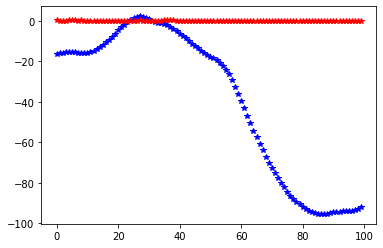

In [17]:
plt.plot(theta[:100],"b*")
plt.plot(ldc[:100],"r*")

In [18]:
vnp = np.array(v)

In [19]:
vnp.min()

-86.40823980420828

In [20]:
par_v.shape

(2097152, 3)